<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
<center>
Авторы материала: Ольга Дайховская (@aiho), Юрий Кашницкий (@yorko). 
    
Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 7 
## <center> Обучение без учителя

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Скачайте данные [отсюда](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице. 

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации. 

Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/19oWnb5CxC5g-Zn45VWjuq_OP8YPCrn_g8Wq3aMaW2U4).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [3]:
X_train = np.loadtxt("../../data/samsung_HAR/samsung_train.txt")
y_train = np.loadtxt("../../data/samsung_HAR/samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("../../data/samsung_HAR/samsung_test.txt")
y_test = np.loadtxt("../../data/samsung_HAR/samsung_test_labels.txt").astype(int)

In [4]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*. 

In [9]:
X_train?

In [12]:
# Ваш код здесь
X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

In [14]:
X.shape, y.shape

((10299, 561), (10299,))

Определим число уникальных значений меток целевого класса.

In [15]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [16]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [17]:
StandardScaler?

In [20]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [24]:
PCA?

In [69]:
# Ваш код здесь
pca = PCA(random_state=RANDOM_STATE, n_components=65)
X_pca = pca.fit_transform(X_scaled)

In [64]:
pca_variance = pca.explained_variance_

In [49]:
total_sum = 0
for x in pca_variance:
    total_sum += x

In [50]:
current_sum = 0
index = 0
for x in pca_variance:
    current_sum += x
    if current_sum > 0.9 * total_sum:
        break
    index += 1

In [51]:
index

64

In [56]:
pca.explained_variance_ratio_[0]

0.5073822103501328

**Вопрос 1:**<br>
Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

In [1]:
# 65

**Варианты:**
- 56 
- 65
- 66
- 193

**Вопрос 2:**<br>
Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов. 

**Варианты:**
- 45
- 51
- 56
- 61

In [58]:
# 51%
pca_variance[0]/sum(pca_variance) * 100

50.73822103501313

Визуализируйте данные в проекции на первые две главные компоненты.

In [59]:
%matplotlib inline

In [61]:
type(X_pca)

sklearn.decomposition.pca.PCA

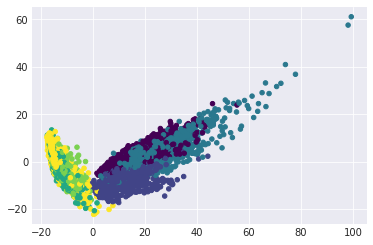

In [70]:
# Ваш код здесь
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, s=20, cmap='viridis');

In [66]:
plt.legend?
# 2

**Вопрос 3:**<br>
Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

------------------------------

Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [74]:
KMeans?

In [73]:
# Ваш код здесь
km = KMeans(n_clusters=6, random_state=RANDOM_STATE, n_init=100)

In [75]:
km.fit(X_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=100, n_jobs=1, precompute_distances='auto',
    random_state=17, tol=0.0001, verbose=0)

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

In [86]:
cluster_labels = km.predict(X_pca)

In [87]:
type(cluster_labels)

numpy.ndarray

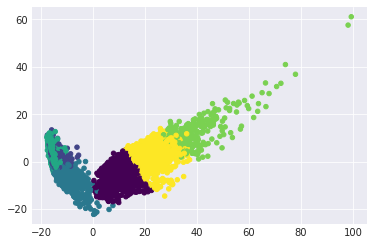

In [89]:
# Ваш код здесь
plt.scatter(X_pca[:,0], X_pca[:,1], s=20, c=cluster_labels, cmap='viridis');

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [90]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,904,0,0,0,78,740,1722
подъем вверх по лестнице,1242,0,2,0,5,295,1544
спуск по лестнице,320,0,0,0,196,890,1406
сидение,1,1235,450,91,0,0,1777
стояние,0,1344,562,0,0,0,1906
лежание,5,53,329,1557,0,0,1944
все,2472,2632,1343,1648,279,1925,10299


In [91]:
max([904.0 / 1722, 1242.0 / 1544, 890.0 / 1406, 1235.0 / 1777, 1344.0 / 1906, 1557.0 / 1944])

0.8044041450777202

In [92]:
1242.0 / 1544

0.8044041450777202

In [93]:
# нету ответа

0.8009259259259259

Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации. 

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,
 
то такая доля будет 900 / 1406 $\approx$ 0.64.
 

**Вопрос 4:**<br>
Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- нет верного ответа

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

In [142]:
# Ваш код здесь
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))
    

HBox(children=(IntProgress(value=0, max=6), HTML(value=u'')))

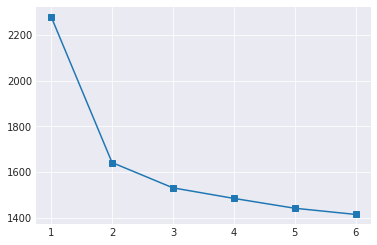

In [146]:
plt.plot(range(1, 7), inertia, marker='s');

**Вопрос 5:**<br>
Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- 2
- 3
- 4

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [94]:
ag = AgglomerativeClustering(n_clusters=n_classes, 
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [95]:
# Ваш код здесь
from sklearn.metrics import adjusted_rand_score

In [99]:
prediction_ag = ag.labels_

In [100]:
adjusted_rand_score(y, cluster_labels)

0.4196778456687551

In [101]:
adjusted_rand_score(y, prediction_ag)

0.4880109976849711

**Вопрос 6:**<br>
Отметьте все верные утверждения.<br>

**Варианты:**
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- В случае случайного разбиения на кластеры ARI будет близок к нулю

-------------------------------

In [102]:
# Все 3

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf). 

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`. 

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), примените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [103]:
secondScaler = StandardScaler()

In [104]:
secondScaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [105]:
# Ваш код здесь
#
X_train_scaled = secondScaler.transform(X_train)
X_test_scaled = secondScaler.transform(X_test)

In [106]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [108]:
gs_lsvc = GridSearchCV(estimator=svc, param_grid=svc_params, cv=3, n_jobs=-1)

In [109]:
gs_lsvc.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=17, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [116]:
# Ваш код здесь
best_svc = gs_lsvc.best_estimator_

In [113]:
gs_lsvc.grid_scores_

C:\Python27\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.92533, std: 0.02126, params: {'C': 0.001},
 mean: 0.93621, std: 0.01445, params: {'C': 0.01},
 mean: 0.93825, std: 0.01429, params: {'C': 0.1},
 mean: 0.92873, std: 0.01486, params: {'C': 1},
 mean: 0.92247, std: 0.01386, params: {'C': 10}]

In [114]:
best_svc

{'C': 0.1}

**Вопрос 7**<br>
Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- 0.1
- 1
- 10

In [117]:
y_predicted = best_svc.predict(X_test_scaled)

In [118]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,4,412,1,1,0,420
сидение,0,4,0,427,60,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,469,412,443,589,526,2947


In [129]:
data = tab.values

In [130]:
data

array([[ 494,    2,    0,    0,    0,    0,  496],
       [  12,  459,    0,    0,    0,    0,  471],
       [   2,    4,  412,    1,    1,    0,  420],
       [   0,    4,    0,  427,   60,    0,  491],
       [   0,    0,    0,   15,  517,    0,  532],
       [   0,    0,    0,    0,   11,  526,  537],
       [ 508,  469,  412,  443,  589,  526, 2947]], dtype=int64)

In [126]:
def precision(data, i):
    return float(data[i][i]) / np.sum(data[i, :])

In [127]:
def recall(data, i):
    return float(data[i][i]) / np.sum(data[:, i])

In [128]:
for i in range(6):
    print precision(data, i), recall(data, i)

0.49798387096774194 0.4862204724409449
0.4872611464968153 0.48933901918976547
0.49047619047619045 0.5
0.434826883910387 0.481941309255079
0.4859022556390977 0.4388794567062818
0.4897579143389199 0.5


In [131]:
# сидение и стояние

**Вопрос 8:**<br>
Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- по точности – стояние, по полноте – сидение 

In [132]:
pca.fit(X_train_scaled)

PCA(copy=True, iterated_power='auto', n_components=65, random_state=17,
  svd_solver='auto', tol=0.0, whiten=False)

In [133]:
X_train_scaled_pca = pca.transform(X_train_scaled)

In [134]:
X_test_scaled_pca = pca.transform(X_test_scaled)

In [135]:
gs_lsvc.fit(X_train_scaled_pca, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=17, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [136]:
best_pca_svc = gs_lsvc.best_estimator_

In [137]:
best_pca_svc

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=17, tol=0.0001,
     verbose=0)

In [138]:
gs_lsvc.grid_scores_

C:\Python27\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.88058, std: 0.01934, params: {'C': 0.001},
 mean: 0.88996, std: 0.02152, params: {'C': 0.01},
 mean: 0.89676, std: 0.02315, params: {'C': 0.1},
 mean: 0.89826, std: 0.02185, params: {'C': 1},
 mean: 0.88656, std: 0.01826, params: {'C': 10}]

In [140]:
(0.93825 - 0.89826) * 100

3.999000000000008

In [141]:
# 4%

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:**<br>
Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- 4% 
- 10%
- 20%


In [ ]:
# 2, 3

**Вопрос 10:**<br>
Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком